## Level 1: Unit sales of all products, aggregated for all stores/states

In [1]:
import os
import numpy as np; np.random.seed(42)
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import plotly.express as px

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.forecaster import CatBoostForecaster
from tsforest.forecaster import XGBoostForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse
from tsforest.trend import fit_prophet_model

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import add_changepoints_to_plot

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator


SEEDS = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [6]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
              "lw_type":lambda x: int(x.unique()),
              "lw_day":lambda x: int(x.unique()),
              "prev_lw":lambda x: int(x.unique()),
              "post_lw":lambda x: int(x.unique()), 
              "prev_christmas":lambda x: int(x.unique()),
              "post_christmas":lambda x: int(x.unique()),
              "prev_thanksgiving":lambda x: int(x.unique()),
             })
        .reset_index()
       )
data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)

In [7]:
data.sort_values(["ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [8]:
scale_factor = np.sqrt(np.nanmean(data.y.diff(1)**2))
scale_factor

5926.012712033271

***

In [9]:
fcst1 = pd.read_csv("../output/forecast_level1-v3.csv", parse_dates=["ds"]).query("ds <= '2016-05-22'")

In [10]:
fcst2_raw = pd.read_csv("../output/submission_witch_time.csv")
fcst2 = fcst1.copy(deep=True)
fcst2["y_pred"] = fcst2_raw.loc[0:30489, [f"F{i}" for i in range(1,29)]].values.sum(axis=0)

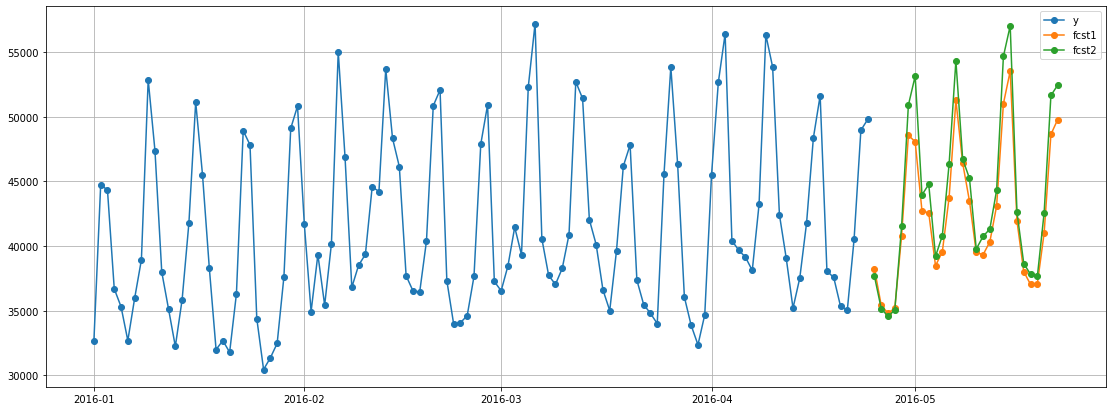

In [11]:
df = data.query("ds >= '2016-01-01'").loc[:, ["ds","y"]]

plt.figure(figsize=(19,7))
plt.plot_date(df.ds, df.y, "o-", label="y")
plt.plot_date(fcst1.ds, fcst1.y_pred, "o-", label="fcst1")
plt.plot_date(fcst2.ds, fcst2.y_pred, "o-", label="fcst2")
plt.grid()
plt.legend(loc="best")
plt.show()

***

In [12]:
# 4 july features
#events_features = make_time_range("2011-01-29", "2016-06-19", "D")
# --
#events_features["prev_4july_day"] = 0
#events_features.loc[events_features.query("ds.dt.month == 7 & ds.dt.day == 3").index, "prev_4july_day"] = 1
# -- 
#events_features["4july_day"] = 0 
#events_features.loc[events_features.query("ds.dt.month == 7 & ds.dt.day == 4").index, "4july_day"] = 1

In [13]:
#data = pd.merge(data, events_features, how="left", on="ds")

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ds                 1913 non-null   datetime64[ns]
 1   y                  1913 non-null   int64         
 2   event_name_1       1913 non-null   int8          
 3   lw_type            1913 non-null   int8          
 4   lw_day             1913 non-null   int8          
 5   prev_lw            1913 non-null   int8          
 6   post_lw            1913 non-null   int8          
 7   prev_christmas     1913 non-null   int8          
 8   post_christmas     1913 non-null   int8          
 9   prev_thanksgiving  1913 non-null   int8          
dtypes: datetime64[ns](1), int64(1), int8(8)
memory usage: 45.0 KB


***

In [15]:
remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

***

In [16]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]

In [17]:
valid_periods = make_valid_periods("2016-04-24", valid_length=28, n_folds=13)
valid_periods

[(Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')),
 (Timestamp('2015-05-25 00:00:00'), Timestamp('2015-06-21 00:00:00')),
 (Timestamp('2015-06-22 00:00:00'), Timestamp('2015-07-19 00:00:00')),
 (Timestamp('2015-07-20 00:00:00'), Timestamp('2015-08-16 00:00:00')),
 (Timestamp('2015-08-17 00:00:00'), Timestamp('2015-09-13 00:00:00')),
 (Timestamp('2015-09-14 00:00:00'), Timestamp('2015-10-11 00:00:00')),
 (Timestamp('2015-10-12 00:00:00'), Timestamp('2015-11-08 00:00:00')),
 (Timestamp('2015-11-09 00:00:00'), Timestamp('2015-12-06 00:00:00')),
 (Timestamp('2015-12-07 00:00:00'), Timestamp('2016-01-03 00:00:00')),
 (Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-31 00:00:00')),
 (Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-28 00:00:00')),
 (Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-27 00:00:00')),
 (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### training validation models

In [34]:
#model_params = {
#    'objective': 'l2', 
#    'metric': 'rmse', 
#    'num_iterations': 314, 
#    'early_stopping_rounds': 1000000, 
#    'bagging_freq': 1, 
#    'learning_rate': 0.28543912663785515, 
#    'num_leaves': 10, 
#    'max_bin': 123, 
#    'feature_fraction': 0.7000000000000001, 
#    'bagging_fraction': 0.8, 
#    'min_data_in_leaf': 5, 
#    'min_gain_to_split': 100000, 
#    'lambda_l2': 0.6845940785471598, 
#    'seed': 71}

lgbm_model_params = {
    'objective': 'l2', 
    'metric': 'rmse',
    'num_iterations': 420, 
    'early_stopping_rounds': 300, 
    'bagging_freq': 1,
    'learning_rate': 0.25386124383432085, 
    'num_leaves': 9, 
    'max_bin': 64, 
    'feature_fraction': 0.5, 
    'bagging_fraction': 1.0, 
    'min_data_in_leaf': 4, 
    'min_gain_to_split': 10000, 
    'lambda_l2': 3.8061891773745047,
    'boost_from_average':False,}

catb_model_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE', 
    'grow_policy': 'SymmetricTree', 
    'sampling_frequency': 'PerTree', 
    'iterations': 300, 
    'learning_rate': 0.27830964143257525, 
    'depth': 5, 
    'max_bin': 255, 
    'rsm': 0.4, 
    'l2_leaf_reg': 9.993984428224122,}


xgb_model_params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse', 
    'tree_method': 'hist', 
    'num_boost_round': 460, 
    'eta': 0.2619995599333314, 
    'grow_policy': 'lossguide', 
    'max_bin': 63, 
    'colsample_bytree': 0.5, 
    'subsample': 0.9, 
    'min_child_weight': 7, 
    'lambda': 2.7626128792219373, 
    'max_depth': 0, 
    'max_leaves': 11,}

prophet_params = {'changepoint_range': 0.97, 
                  #'changepoint_prior_scale': 0.08136694489257186, 
                  'changepoint_prior_scale': 0.1, 
                  'wk_fourier_order': 4, 
                  'wk_prior_scale': 7, 
                  'yr_fourier_order': 5, 
                  'yr_prior_scale': 2,
                  'n_changepoints': 25,}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    #"model_params":catb_model_params,
    #"model_params":lgbm_model_params,
    "model_params":xgb_model_params,
    "time_features":time_features,
    "categorical_features":{"event_name_1":"default"},
    "copy":True,
}

In [35]:
# 4+ years of history
train_history = 1800

***

############################################### 1/13 ###############################################
##### Validation period: (Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-27 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1359.58it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2727.86
[50]	valid_0's rmse: 2411.08
[75]	valid_0's rmse: 2352.64
[100]	valid_0's rmse: 2337.71
[125]	valid_0's rmse: 2311.51
[150]	valid_0's rmse: 2280.64
[175]	valid_0's rmse: 2271.1
[200]	valid_0's rmse: 2295.09
[225]	valid_0's rmse: 2325.31
[250]	valid_0's rmse: 2326.99
[275]	valid_0's rmse: 2312.27
[300]	valid_0's rmse: 2326.56
[325]	valid_0's rmse: 2330.15
[350]	valid_0's rmse: 2330.47
[375]	valid_0's rmse: 2330.1
[400]	valid_0's rmse: 2327.83
Did not meet early stopping. Best iteration is:
[176]	valid_0's rmse: 2269.15
RMSE: 2269.154736216713
RMSSE: 0.382914253897735


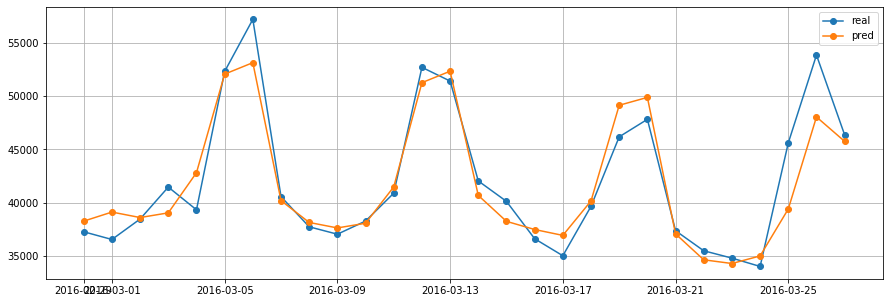

############################################### 2/13 ###############################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1521.88it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2616.32
[50]	valid_0's rmse: 2091.73
[75]	valid_0's rmse: 1922.15
[100]	valid_0's rmse: 1891.71
[125]	valid_0's rmse: 1899.86
[150]	valid_0's rmse: 1836.12
[175]	valid_0's rmse: 1837.03
[200]	valid_0's rmse: 1830.61
[225]	valid_0's rmse: 1847
[250]	valid_0's rmse: 1752.58
[275]	valid_0's rmse: 1752.33
[300]	valid_0's rmse: 1718.5
[325]	valid_0's rmse: 1716.27
[350]	valid_0's rmse: 1706.39
[375]	valid_0's rmse: 1687.65
[400]	valid_0's rmse: 1719.61
Did not meet early stopping. Best iteration is:
[377]	valid_0's rmse: 1686.92
RMSE: 1686.917756060997
RMSSE: 0.2846632023983964


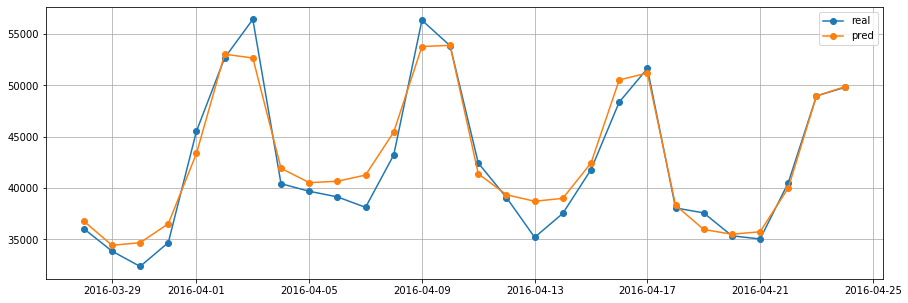

In [120]:
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods[-2:]):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["trend_models"] = compute_trend_models(_train_data, _valid_index)
    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);    
    _fcaster.fit(fit_kwargs={"verbose_eval":25})

    errors.append(_fcaster.model.model.best_score["valid_0"]["rmse"]/scale_factor)
    best_iterations.append(_fcaster.best_iteration)

    predictions = _fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")])    
    predictions = pd.merge(predictions,
                           _fcaster.valid_features.loc[:, ["ds","y_raw"]], 
                           how="inner", 
                           on=["ds"]).rename({"y_raw":"y"}, axis=1)
    
    print(f"RMSE: {errors[-1]*scale_factor}")
    print(f"RMSSE: {errors[-1]}")
    plt.figure(figsize=(15,5))
    plt.plot_date(predictions.ds, predictions.y, "o-", label="real")
    plt.plot_date(predictions.ds, predictions.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [12]:
np.mean(np.sort(best_iterations)[1:-1])

296.45454545454544

In [13]:
np.mean(errors)

0.2819159981311896

***
# trend estimation

In [36]:
prophet_params = {'changepoint_range': 0.97, 
                  #'changepoint_prior_scale': 0.08136694489257186, 
                  'changepoint_prior_scale': 1., 
                  'wk_fourier_order': 4, 
                  'wk_prior_scale': 7, 
                  'yr_fourier_order': 5, 
                  'yr_prior_scale': 2,
                  'n_changepoints': 25}
prophet_params

{'changepoint_range': 0.97,
 'changepoint_prior_scale': 1.0,
 'wk_fourier_order': 4,
 'wk_prior_scale': 7,
 'yr_fourier_order': 5,
 'yr_prior_scale': 2,
 'n_changepoints': 25}

In [37]:
m = fit_prophet_model(data.loc[:, ["ds","y"]], kwargs=prophet_params)
future = m.make_future_dataframe(periods=56)
forecast = m.predict(future)

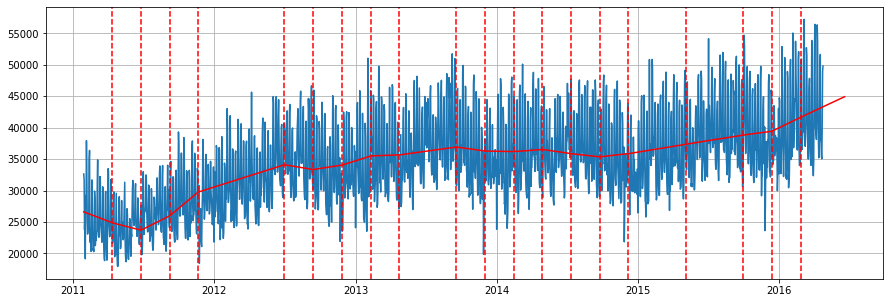

In [38]:
fig = plt.figure(figsize=(15,5))
plt.plot_date(data.ds, data.y, "-")
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.grid()
plt.show()

***
### training final models

In [39]:
model_kwargs["model_params"]

{'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'tree_method': 'hist',
 'num_boost_round': 460,
 'eta': 0.2619995599333314,
 'grow_policy': 'lossguide',
 'max_bin': 63,
 'colsample_bytree': 0.5,
 'subsample': 0.9,
 'min_child_weight': 7,
 'lambda': 2.7626128792219373,
 'max_depth': 0,
 'max_leaves': 11}

In [40]:
model_kwargs["time_features"]

['year',
 'month',
 'year_week',
 'year_day',
 'week_day',
 'month_progress',
 'year_day_cos',
 'year_day_sin',
 'year_week_cos',
 'year_week_sin']

In [41]:
%%time
train_data = data.copy(deep=True)
all_models = list()

for seed in SEEDS:
    model_kwargs["trend_models"] = compute_trend_models(train_data, model_kwargs=prophet_params)
    # --
    model_kwargs["model_params"]["seed"] = seed    
    fcaster = XGBoostForecaster(**model_kwargs)
    # --
    #model_kwargs["model_params"]["seed"] = seed    
    #fcaster = LightGBMForecaster(**model_kwargs)
    # --
    #model_kwargs["model_params"]["random_seed"] = seed
    #fcaster = CatBoostForecaster(**model_kwargs)
    fcaster.prepare_features(train_data=train_data);
    fcaster.fit()
    all_models.append(fcaster)

100%|██████████| 1/1 [00:00<00:00, 1108.72it/s]


CPU times: user 11min 34s, sys: 2min 52s, total: 14min 27s
Wall time: 2min 42s


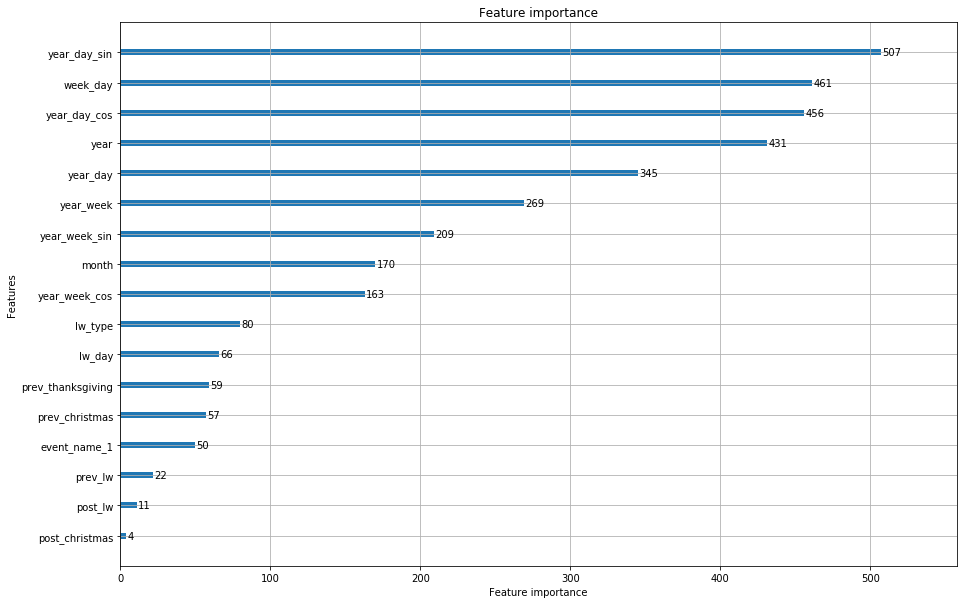

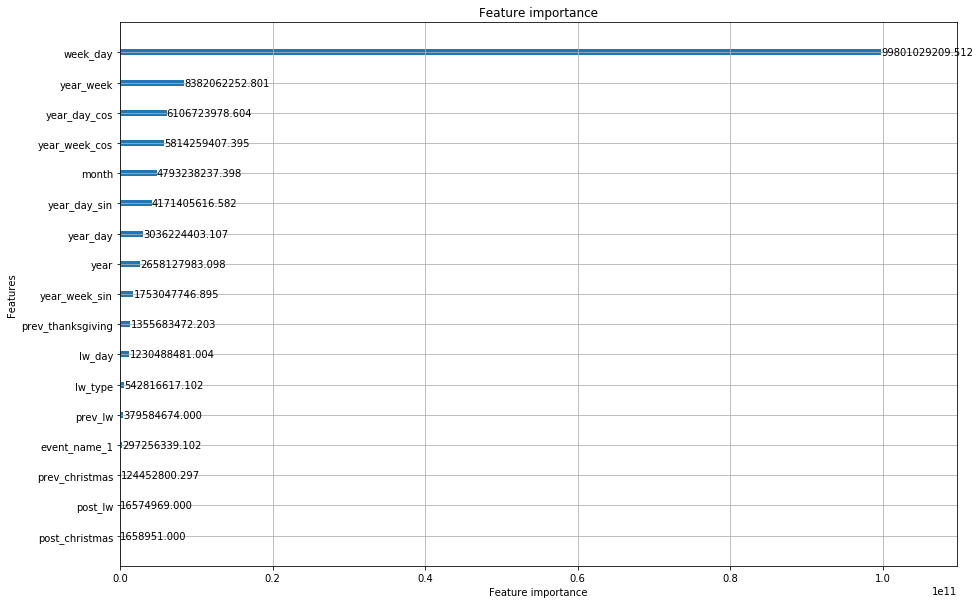

In [127]:
fcaster = all_models[7]
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

In [43]:
from xgboost import plot_importance, plot_tree

<Figure size 720x360 with 0 Axes>

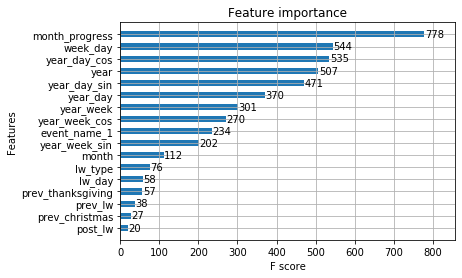

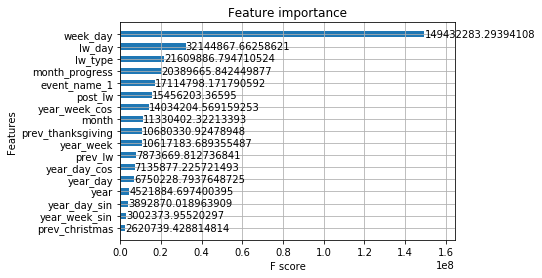

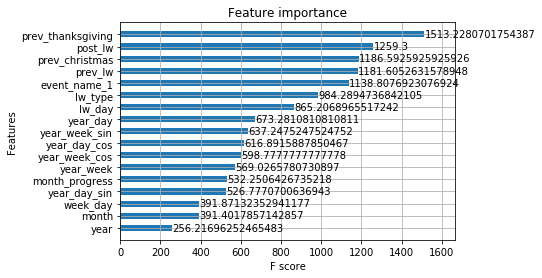

In [42]:
fcaster = all_models[7]

plt.figure(figsize=(10,5))
plot_importance(fcaster.model.model, importance_type="weight", height=0.5)
plot_importance(fcaster.model.model, importance_type="gain", height=0.5)
plot_importance(fcaster.model.model, importance_type="cover", height=0.5)
plt.show()

In [46]:
#importance_dataframe = pd.DataFrame({"feature":all_models[0].input_features,
#                                     "importance": all_models[0].model.model.get_feature_importance()})
#importance_dataframe.sort_values("importance", ascending=False)

In [47]:
all_models[0].input_features

['_internal_ts_uid',
 'year',
 'month',
 'year_week',
 'year_day',
 'week_day',
 'month_progress',
 'year_day_cos',
 'year_day_sin',
 'year_week_cos',
 'year_week_sin',
 'lw_type',
 'lw_day',
 'prev_lw',
 'post_lw',
 'prev_christmas',
 'post_christmas',
 'prev_thanksgiving',
 'event_name_1']

***

In [50]:
valid_dataframe = (pd.read_parquet("../input/valid_dataframe.parquet")
                   .loc[:, train_data.columns.drop(["y"])]
                   #.assign(weight = train_data.weight.max())
                   .drop_duplicates())
eval_dataframe = (pd.read_parquet("../input/eval_dataframe.parquet")
                  .loc[:, train_data.columns.drop(["y"])]
                  #.assign(weight = train_data.weight.max())
                  .drop_duplicates())

In [52]:
all_forecasts = list()
for fcaster in all_models:
    _forecast = fcaster.predict(pd.concat([valid_dataframe, eval_dataframe], ignore_index=True))
    all_forecasts.append(_forecast)
    
forecast = all_forecasts[0].copy(deep=True)
forecast["y_pred"] = np.mean([_forecast.y_pred for _forecast in all_forecasts], axis=0)

In [56]:
#forecast_020 = forecast.copy(deep=True)
#forecast_010 = forecast.copy(deep=True)
#forecast_005 = forecast.copy(deep=True)
#forecast_stl = forecast.copy(deep=True)
#forecast_001 = forecast.copy(deep=True)
#forecast_1000 = forecast.copy(deep=True)

In [57]:
print(forecast.y_pred.sum() / 1e6)
print(forecast.y_pred.mean())

2.4422516130859377
43611.63594796317


In [27]:
print(forecast.y_pred.sum() / 1e6)
print(forecast.y_pred.mean())

2.4452655789002375
43665.456766075666


In [31]:
print(forecast.y_pred.sum() / 1e6)
print(forecast.y_pred.mean())

2.4407326989150184
43584.512480625344


In [50]:
print(forecast.y_pred.sum() / 1e6)
print(forecast.y_pred.mean())

2.3382460588017904
41754.39390717483


In [23]:
print(forecast.y_pred.sum() / 1e6)
print(forecast.y_pred.mean())

2.338196133997388
41753.50239281049


In [30]:
print(forecast.y_pred.sum() / 1e6)
print(forecast.y_pred.mean())

2.4400115987162327
43571.635691361305


In [38]:
print(forecast_314.y_pred.sum() / 1e6)
print(forecast_314.y_pred.mean())

2.3861854653919377
42610.45473914174


In [45]:
print(forecast_400.y_pred.sum() / 1e6)
print(forecast_400.y_pred.mean())

2.3848045423876076
42585.795399778704


In [53]:
print(forecast_500.y_pred.sum() / 1e6)
print(forecast_500.y_pred.mean())

2.3849283402587416
42588.00607604896


In [60]:
print(forecast_750.y_pred.sum() / 1e6)
print(forecast_750.y_pred.mean())

2.3904250694343747
42686.16195418525


In [73]:
print(forecast_1000.y_pred.sum() / 1e6)
print(forecast_1000.y_pred.mean())

2.389963635301196
42677.922058949924


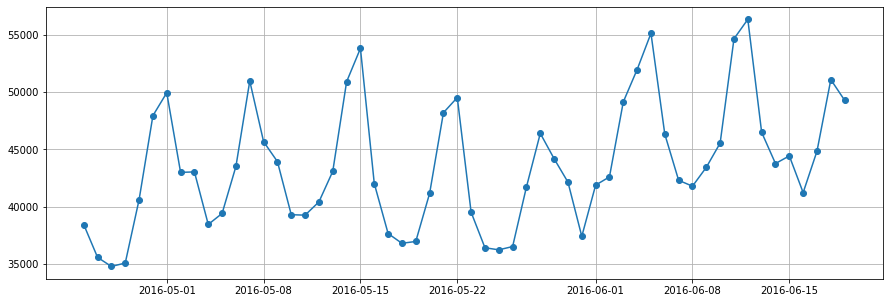

In [58]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast.ds, forecast.y_pred, "o-")
plt.grid()
plt.show()

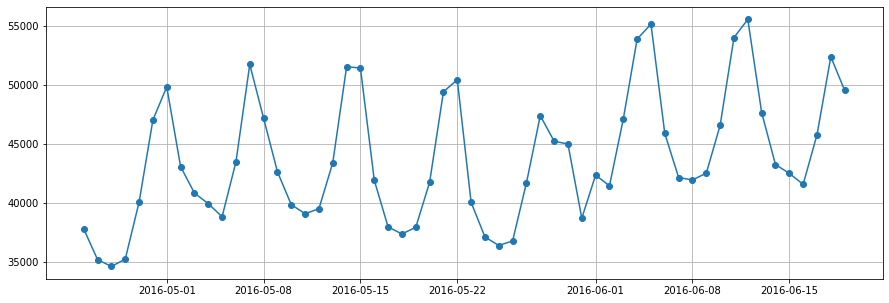

In [135]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast.ds, forecast.y_pred, "o-")
plt.grid()
plt.show()

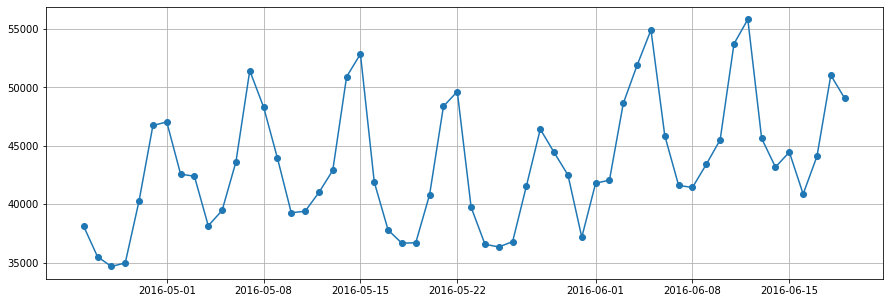

In [117]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast.ds, forecast.y_pred, "o-")
plt.grid()
plt.show()

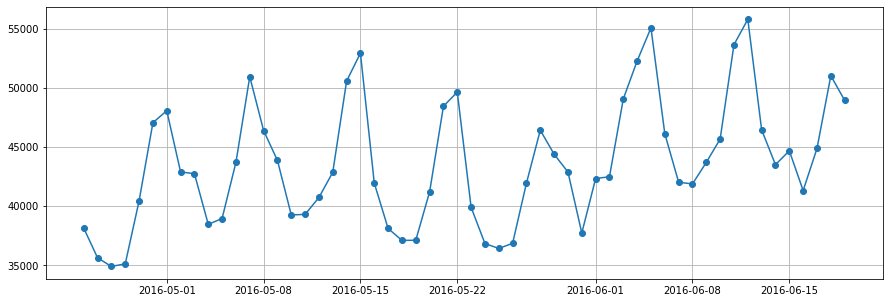

In [32]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast.ds, forecast.y_pred, "o-")
plt.grid()
plt.show()

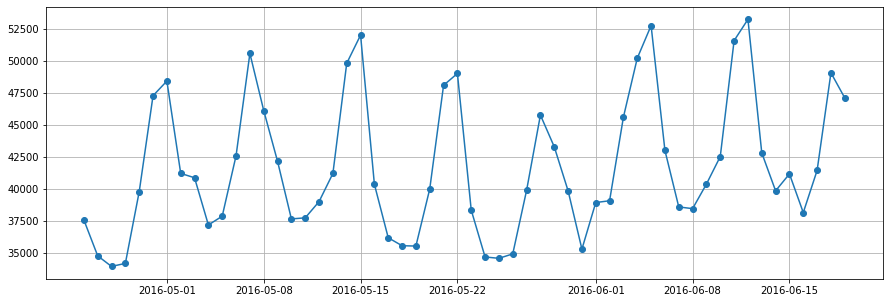

In [51]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast.ds, forecast.y_pred, "o-")
plt.grid()
plt.show()

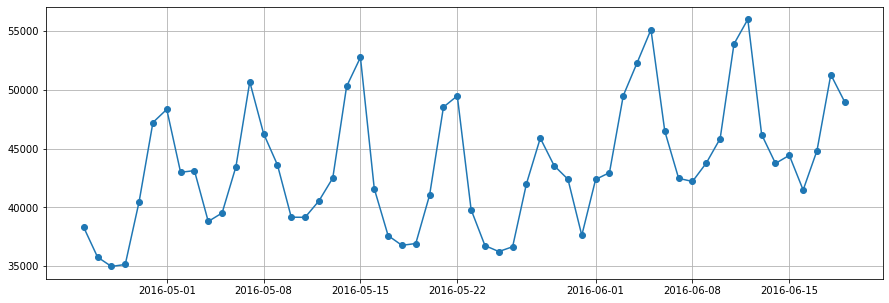

In [31]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast.ds, forecast.y_pred, "o-")
plt.grid()
plt.show()

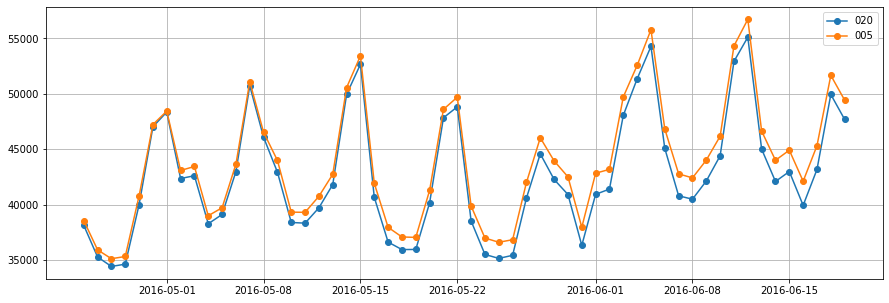

In [56]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast_020.ds, forecast_020.y_pred, "o-", label="020")
#plt.plot_date(forecast_010.ds, forecast_010.y_pred, "o-", label="010")
plt.plot_date(forecast_005.ds, forecast_005.y_pred, "o-", label="005")
#plt.plot_date(forecast_stl.ds, forecast_stl.y_pred, "o-", label="stl")
#plt.plot_date(forecast_001.ds, forecast_001.y_pred, "o-", label="001")
#plt.plot_date(forecast_750.ds, forecast_750.y_pred, "o-", label="750")
#plt.plot_date(forecast.ds, forecast.y_pred, "o-", label="0.98")
plt.grid()
plt.legend(loc="best")
plt.show()

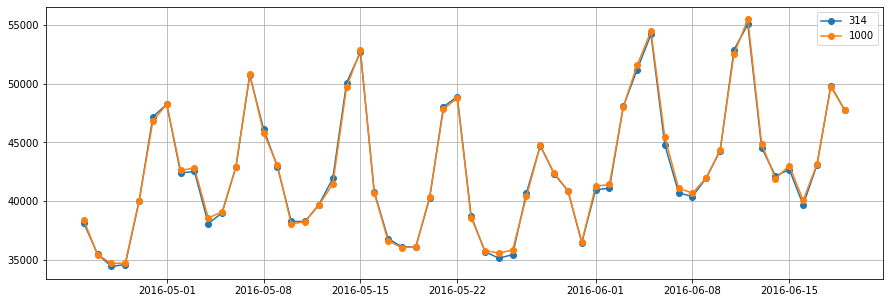

In [75]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast_314.ds, forecast_314.y_pred, "o-", label="314")
#plt.plot_date(forecast_400.ds, forecast_400.y_pred, "o-", label="400")
#plt.plot_date(forecast_500.ds, forecast_500.y_pred, "o-", label="500")
#plt.plot_date(forecast_750.ds, forecast_750.y_pred, "o-", label="750")
plt.plot_date(forecast_1000.ds, forecast_1000.y_pred, "o-", label="1000")
plt.grid()
plt.legend(loc="best")
plt.show()

***
### estimating residuals

In [42]:
%%time
left_date = train_data.ds.max() - pd.DateOffset(years=3)

all_predictions = list()
for fcaster in all_models:
    predictions = fcaster.predict(train_data.query("ds >= @left_date").loc[:, data.columns.drop("y")])
    all_predictions.append(predictions)
predictions = all_predictions[0].copy(deep=True)
predictions["y_pred"] = np.mean([_predictions.y_pred for _predictions in all_predictions], axis=0)

CPU times: user 1.47 s, sys: 84.4 ms, total: 1.56 s
Wall time: 1.15 s


In [43]:
residuals_raw = (pd.merge(train_data, predictions, how="inner", on=["ds"])
                 .assign(residual = lambda x: x.y - x.y_pred)
                 .loc[:, ["ds","y","y_pred","residual"]])

In [44]:
q01 = residuals_raw.residual.quantile(0.01)
q99 = residuals_raw.residual.quantile(0.99)
residuals_raw.query("@q01 <= residual <= @q99").residual.std()

902.1738429014322

In [45]:
#%%time
#n_repetitions = 20
#sample_size = 0.66
#all_residual_deviance = list()
#for i in range(n_repetitions):
#    _residual_deviance = residuals_raw.sample(frac=0.66).residual.std()
#    all_residual_deviance.append(_residual_deviance)

In [46]:
#residuals = (pd.merge(train_data, predictions, how="inner", on="ds")
#             .assign(residual = lambda x: x.y - x.y_pred))
#q01 = residuals.residual.quantile(0.01)
#q99 = residuals.residual.quantile(0.99)
#residuals.query("@q01 < residual < @q99").residual.std()

***
### prediction

In [47]:
valid_dataframe = (pd.read_parquet("../input/valid_dataframe.parquet")
                   .loc[:, train_data.columns.drop("y")]
                   .drop_duplicates())
eval_dataframe = (pd.read_parquet("../input/eval_dataframe.parquet")
                  .loc[:, train_data.columns.drop("y")]
                  .drop_duplicates())

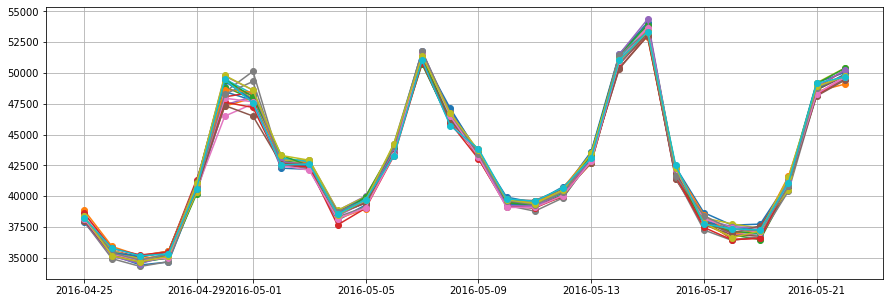

In [48]:
# visualizing the predictions over the validation period
plt.figure(figsize=(15,5))
for i,fcaster in enumerate(all_models):
    _forecast = fcaster.predict(valid_dataframe)    
    plt.plot_date(_forecast.ds, _forecast.y_pred, "o-", label=f"seed: {i}")
plt.grid()
plt.show()

In [49]:
all_forecasts = list()
for fcaster in all_models:
    _forecast = fcaster.predict(pd.concat([valid_dataframe, eval_dataframe], ignore_index=True))
    all_forecasts.append(_forecast)
    
forecast = all_forecasts[0].copy(deep=True)
forecast["y_pred"] = np.mean([_forecast.y_pred for _forecast in all_forecasts], axis=0)

In [50]:
forecast.to_csv("../output/forecast_level1-v3.csv", index=False)

***

In [43]:
import plotly.express as px

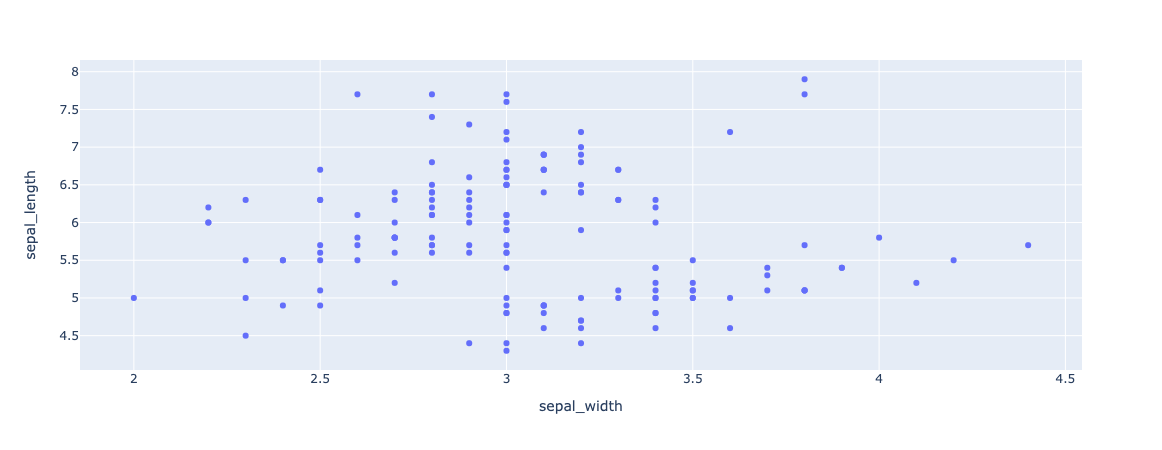

In [45]:
df = px.data.iris()
fig = px.scatter(df, x="sepal_width", y="sepal_length")
fig.show()